In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

from tqdm import tqdm_notebook as tqdm


# Feature Engineering

In [2]:
df = pd.read_json('data/full_pipe/data_features.json', lines= True)
df.columns

Index(['distance_mrt', 'town', 'flat_num', 'age_transation', 'lease_commence',
       'transaction_yr', 'transaction', 'storey_height', 'resale_price',
       'resale_price_adj', 'Postal', 'Location'],
      dtype='object')

In [3]:
columns = ['distance_mrt','age_transation','transaction_yr','Postal','storey_height', 'resale_price_adj','town','flat_num']

df_chosen = df[columns].copy()
df_chosen = df_chosen[df_chosen['Postal']!='NIL'] #remove the items with no postal code#
df_chosen['Postal'] = df_chosen['Postal'].astype(int)  #convert to int

print(df_chosen.shape[0], 'filtered out of:', df.shape[0])
df_chosen.columns

129045 filtered out of: 129809


Index(['distance_mrt', 'age_transation', 'transaction_yr', 'Postal',
       'storey_height', 'resale_price_adj', 'town', 'flat_num'],
      dtype='object')

In [4]:
df_chosen.isna().sum()  #confirm no NA values

distance_mrt        0
age_transation      0
transaction_yr      0
Postal              0
storey_height       0
resale_price_adj    0
town                0
flat_num            0
dtype: int64

In [5]:
df_chosen.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129045 entries, 0 to 129808
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance_mrt      129045 non-null  float64
 1   age_transation    129045 non-null  int64  
 2   transaction_yr    129045 non-null  int64  
 3   Postal            129045 non-null  int32  
 4   storey_height     129045 non-null  int64  
 5   resale_price_adj  129045 non-null  float64
 6   town              129045 non-null  object 
 7   flat_num          129045 non-null  object 
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 8.4+ MB


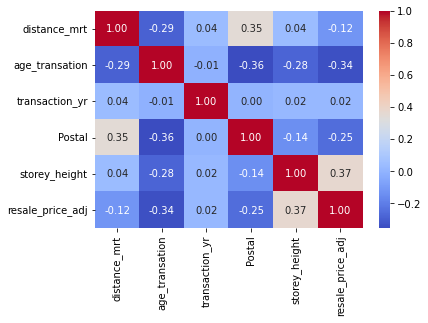

In [6]:
continuous_features = ['distance_mrt','age_transation','transaction_yr','Postal','storey_height', 'resale_price_adj']
g = sns.heatmap(df_chosen[continuous_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

None of the parameters have correlation of 1 to each other. This indicates that colinearity is not an issue.

In addition, transaction year has little effect on the resale adjusted price. This indicate the adjustment using resale price index was good.

In [7]:
#Create different columns for categorical values ['town', 'flatnum']
df_chosen = pd.get_dummies(df_chosen)
df_chosen.columns

Index(['distance_mrt', 'age_transation', 'transaction_yr', 'Postal',
       'storey_height', 'resale_price_adj', 'town_ANG MO KIO', 'town_BEDOK',
       'town_BISHAN', 'town_BUKIT BATOK', 'town_BUKIT MERAH',
       'town_BUKIT PANJANG', 'town_BUKIT TIMAH', 'town_CENTRAL AREA',
       'town_CHOA CHU KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG EAST', 'town_JURONG WEST', 'town_KALLANG/WHAMPOA',
       'town_MARINE PARADE', 'town_PASIR RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_num_1 ROOM', 'flat_num_2 ROOM', 'flat_num_3 ROOM',
       'flat_num_4 ROOM', 'flat_num_5 ROOM', 'flat_num_EXECUTIVE',
       'flat_num_MULTI-GENERATION'],
      dtype='object')

In [8]:
#Create train and test sets
model_data = df_chosen.copy()

X = model_data.drop('resale_price_adj', axis=1)
y = model_data['resale_price_adj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

# Model Selection

In [9]:
models = [LinearRegression(), Ridge(), RandomForestRegressor(), GradientBoostingRegressor()]
for m in tqdm(models):
    model = make_pipeline(StandardScaler(),m)
    model.fit(X_train, y_train)  # apply scaling on training data
    print("="*100)
    print('For model', m)
    print('Model score is:', model.score(X_test, y_test))
    print('Mean Absolute Error:', mean_absolute_error(y_test, model.predict(X_test)))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

<ipython-input-9-65a3d8006b88>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for m in tqdm(models):


  0%|          | 0/4 [00:00<?, ?it/s]

For model LinearRegression()
Model score is: 0.8360058821281908
Mean Absolute Error: 46080.041686465695
Root Mean Squared Error: 61774.962690243316
For model Ridge()
Model score is: 0.8360431187806779
Mean Absolute Error: 46085.84165664462
Root Mean Squared Error: 61767.948952679355
For model RandomForestRegressor()
Model score is: 0.9651814972460009
Mean Absolute Error: 20026.677189221664
Root Mean Squared Error: 28464.489688191366
For model GradientBoostingRegressor()
Model score is: 0.888104879650156
Mean Absolute Error: 36041.20527731103
Root Mean Squared Error: 51027.45755111087


In [23]:
##Testing out decision trees with optimizing for depth
x_axis = []
y_axis = []
score = []

print('testing out decision tree, OneHot, normalized')
for i in range(15,30):
    dt = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=i,random_state=27))
    dt.fit(X_train,y_train)
    pred = dt.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,pred))
    # print('rmse for decision tree, OneHot, normalized:', rmse)
    x_axis.append(i)
    y_axis.append(rmse)
    score.append(dt.score(X_test, y_test))

min_rmse = min(y_axis)
min_depth = x_axis[y_axis.index(min_rmse)]
max_score = score[y_axis.index(min_rmse)]
print('rmse for decision tree, OneHot, normalized:', min_rmse, 'at depth =', min_depth, 'with r2 at', max_score)


testing out decision tree, OneHot, normalized
rmse for decision tree, OneHot, normalized: 35847.63377007177 at depth = 19 with r2 at 0.9447764558277396


Text(0, 0.5, 'RMSE')

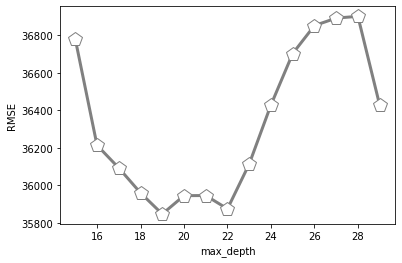

In [25]:
plt.plot(x_axis, y_axis, '-p', color='gray',
         markersize=15, linewidth=3,
         markerfacecolor='white',
         markeredgecolor='gray',
         markeredgewidth=1)

plt.xlabel("max_depth")
plt.ylabel("RMSE")

So far the two best algorithms are the randomforest and decision tree algorihtms. Let us see the breakdown of contributions by each feature for both

In [11]:
#Decision tree model
dt = make_pipeline(StandardScaler(),DecisionTreeRegressor(max_depth=22,random_state=27))
dt.fit(X_train,y_train)
pred = dt.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
print('rmse for decision tree:', rmse)

#Randomforest model
model = make_pipeline(StandardScaler(),RandomForestRegressor())
model.fit(X_train, y_train) 
print('rmse for randomforest', np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

rmse for decision tree: 35875.2564534136
rmse for randomforest 28465.761413054253


In [26]:

feature_importances = pd.DataFrame(model.steps[1][1].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
                                    
feature_importances

,importance
Postal,0.251385
flat_num_3 ROOM,0.245478
age_transation,0.141285
flat_num_EXECUTIVE,0.108566
flat_num_5 ROOM,0.078541
distance_mrt,0.045479
storey_height,0.029064
town_BISHAN,0.023681
flat_num_2 ROOM,0.016861
flat_num_4 ROOM,0.014835


In [13]:

feature_importances = pd.DataFrame(model.steps[1][1].feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

#Adding in feature names
model.feature_names = list(X_train.columns.values)

In [14]:
# save the randomforest model to disk
import pickle
filename = 'model/finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [15]:
###Reload the randomforest model to try out on actual data###
import pickle
import os

filename = 'model/finalized_model.sav'

# saving/loading data
if os.path.exists("./model/finalized_model.sav"):
    model = pickle.load(open(filename, 'rb'))
    print('loaded model')
else:
    pickle.dump(model, open(filename, 'wb'))

loaded model


In [16]:
#extract feature names#
feature_names = model.feature_names
input = [0]*len(feature_names)

In [17]:
input[0] = 1        #1km to MRT (roughly)
input[1] = 27       #25 years old
input[2] = 2022     #will be transacting this year
input[3] = 680705   #postal code
input[4] = 12       #Height is 4 (floor 12)
input[13] = 1       #Choa chu kang
input[35] = 1       #5 room flat


In [18]:
Actual =dict(zip(feature_names,input))
Actual_df = pd.DataFrame(Actual, index=[0])

In [19]:
resale_adj_price = model.predict(Actual_df)[0]
price = resale_adj_price*168.1/133.9

print('resale 5 room flat at Choa Chu Kang should be selling for:', price)

resale 5 room flat at Choa Chu Kang should be selling for: 588151.0222326157


https://www.srx.com.sg/hdb/choa-chu-kang/choa-chu-kang-street-53-hscho0021/680705/hdb-listings

Price transacted on SRX was 585k.